<a href="https://colab.research.google.com/github/rednam-ntn/layout-parser/blob/master/examples/Layout%20Parsing%20Detectron2%20PrimaLayout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Layout Parsing

In this tutorial, we will show how to use the `layoutparser` API to 

1. Load Deep Learning Layout Detection models and predict the layout of the paper image
2. Use the coordinate system to parse the output 

The `paper-image` is from https://arxiv.org/abs/2004.08686.

In [1]:
!pip install layoutparser torch

     |████████████████████████████████| 19.2 MB 118 kB/s 
     |████████████████████████████████| 636 kB 41.9 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 5.6 MB 32.7 MB/s 
     |████████████████████████████████| 139 kB 47.3 MB/s 
     |████████████████████████████████| 1.9 MB 36.1 MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.5.28-py3-none-any.whl size=32240 sha256=abd084a28892d6c4f498d2f80ffb62359d58692980ce1d8b301caf9f03996a5c
  Stored in directory: /root/.cache/pip/wheels/f2/b1/a0/c0a77b756d580f53b3806ae0e0b3ec945a8d05fca1d6e10cc1
Successfully built pdfplumber
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"

In [3]:
import layoutparser as lp
import cv2

In [6]:
!ls -l sample_data

total 57388
-rwxr-xr-x 1 root root     1697 Jan  1  2000 anscombe.json
-rw-r--r-- 1 root root   301141 Sep 16 13:40 california_housing_test.csv
-rw-r--r-- 1 root root  1706430 Sep 16 13:40 california_housing_train.csv
-rw-r--r-- 1 root root 18289443 Sep 16 13:40 mnist_test.csv
-rw-r--r-- 1 root root 36523880 Sep 16 13:40 mnist_train_small.csv
-rwxr-xr-x 1 root root      930 Jan  1  2000 README.md
-rw-r--r-- 1 root root   541014 Sep 20 08:56 RICBA0698300_0-0.png
-rw-r--r-- 1 root root   443647 Sep 20 08:56 RICBAD333700_0-0.png
-rw-r--r-- 1 root root   516730 Sep 20 08:56 RICBAG653800_0-0.png
-rw-r--r-- 1 root root   413864 Sep 20 08:56 SINB17512600_0.png


In [5]:
lp.is_detectron2_available()

True

## Use Layout Models to detect complex layout 

`layoutparser` can identify the layout of the given document with only 4 lines of code.

In [25]:
model = lp.Detectron2LayoutModel(
    'lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config',
    extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
    label_map={1:"TextRegion", 2:"ImageRegion", 3:"TableRegion", 4:"MathsRegion", 5:"SeparatorRegion", 6:"OtherRegion"}
)

# Load the deep layout model from the layoutparser API 
# For all the supported model, please check the Model 
# Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


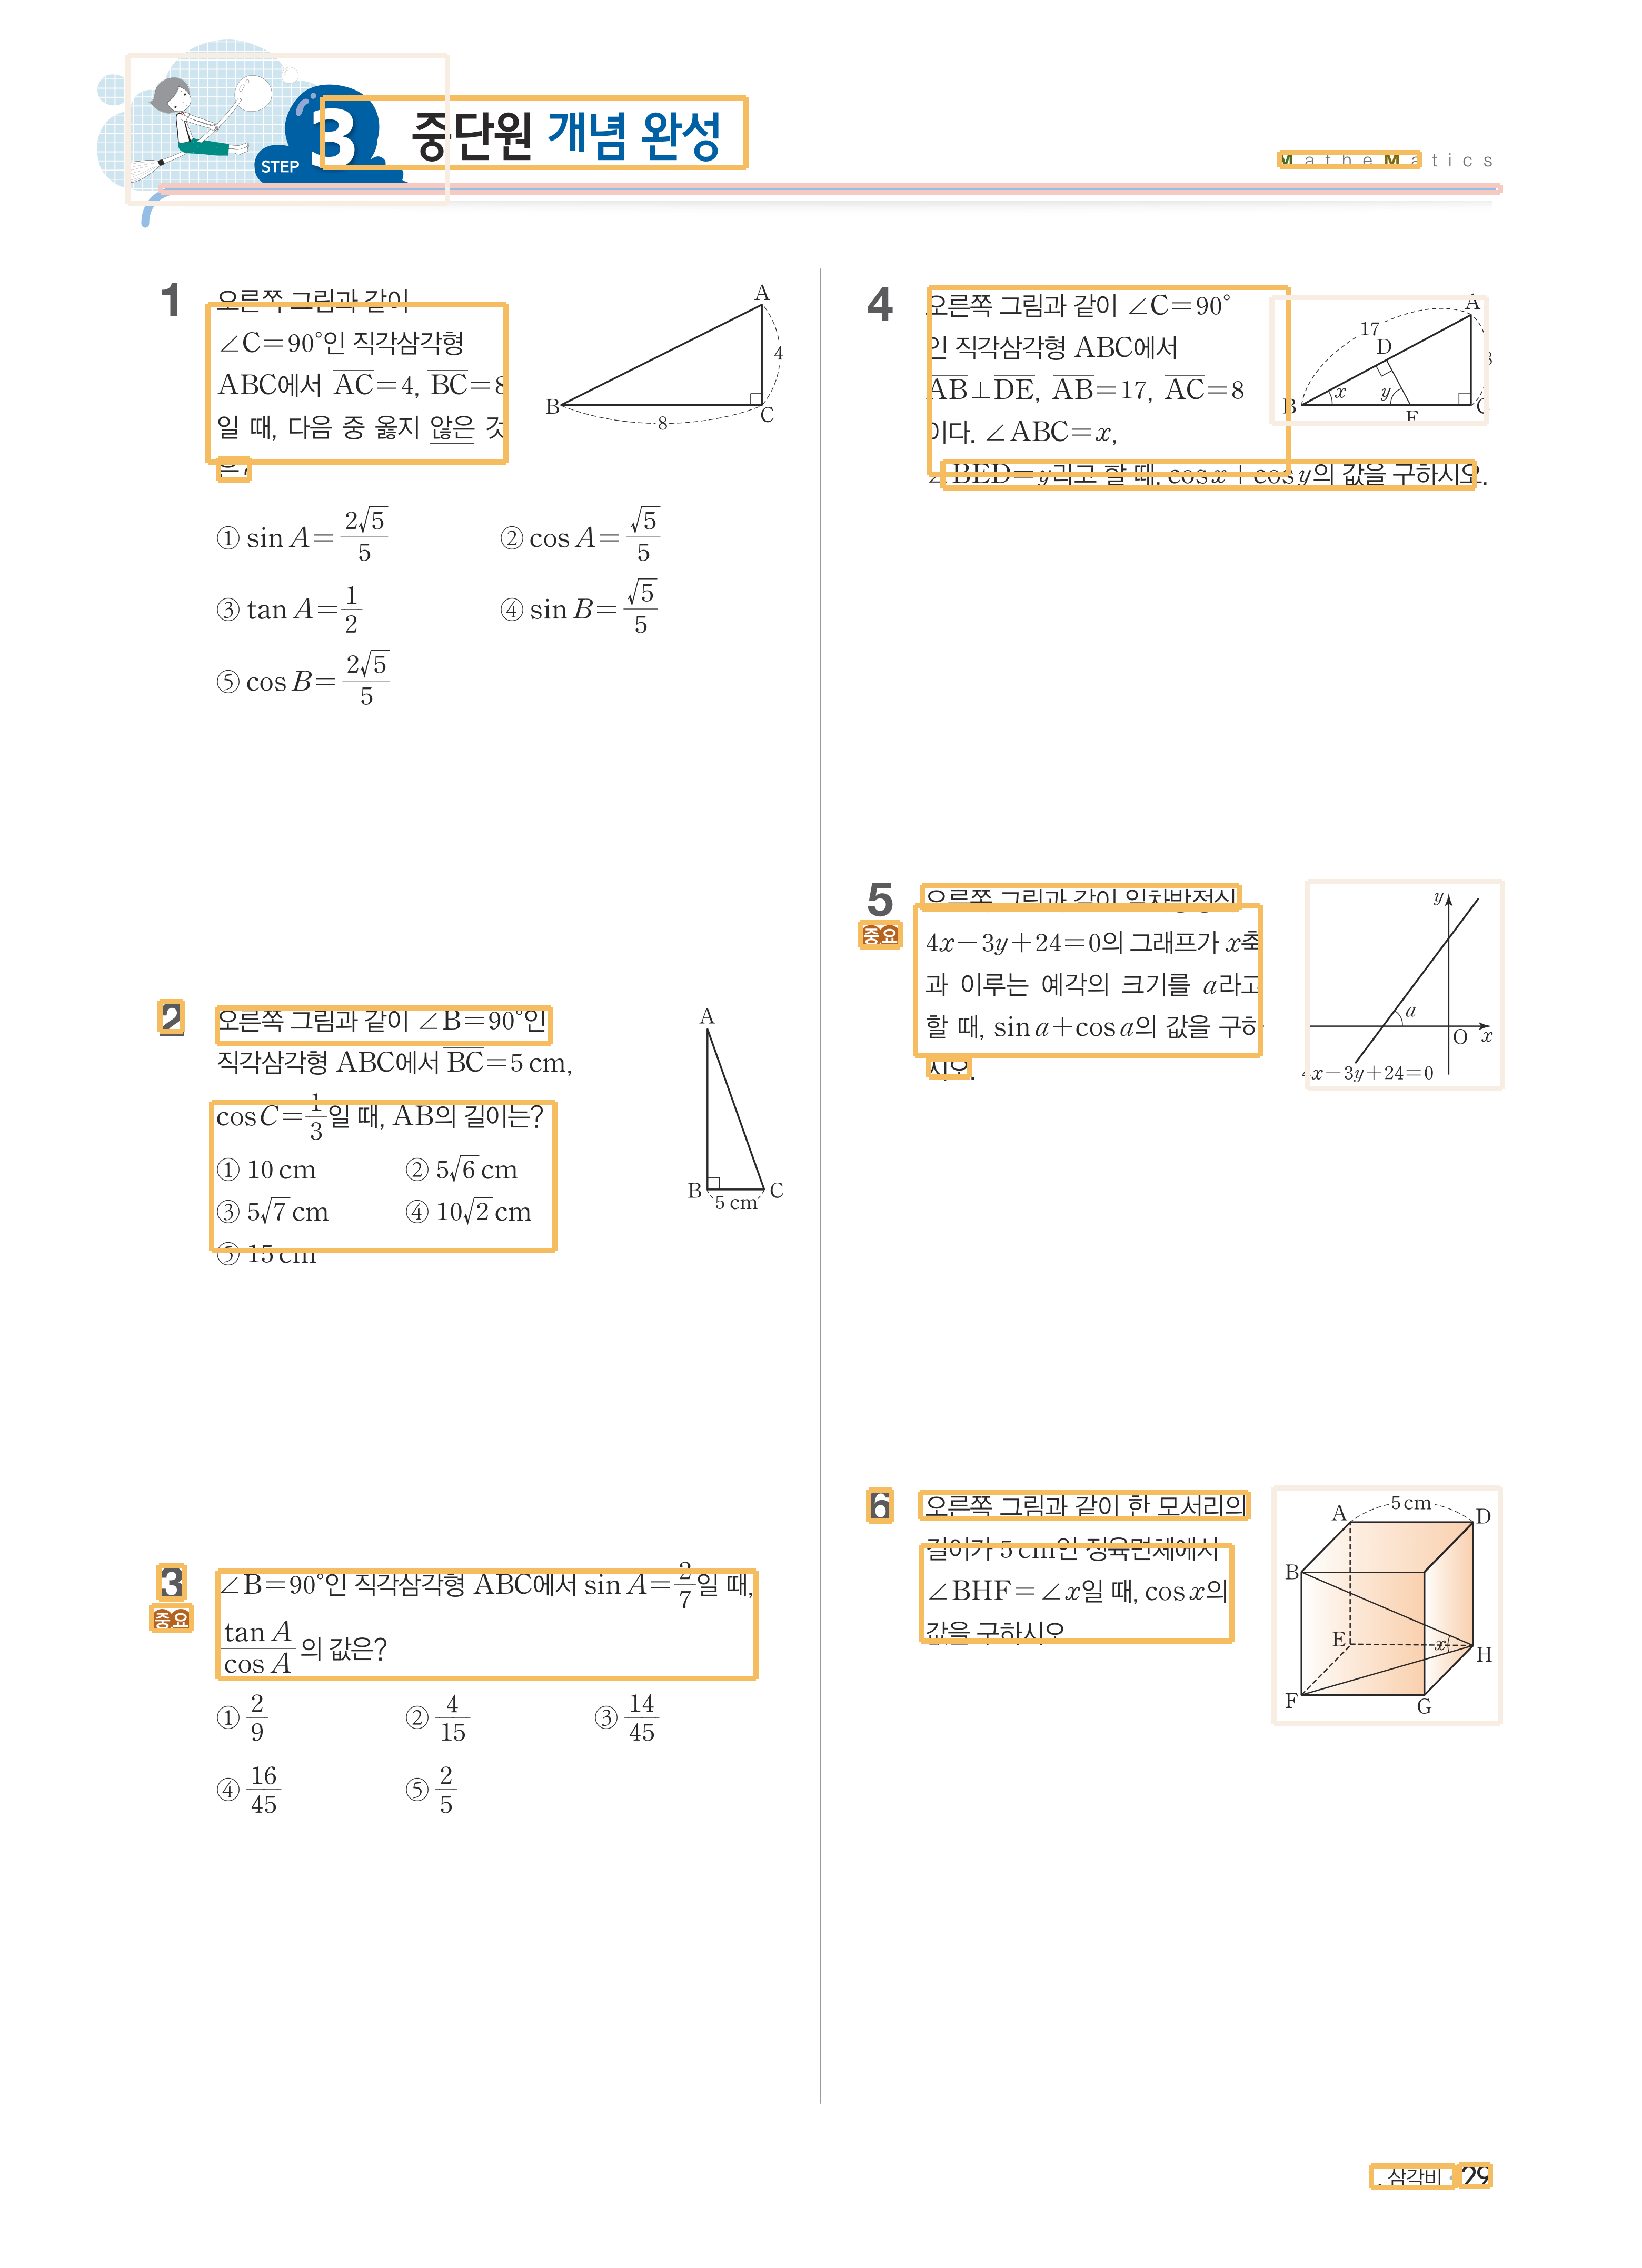

In [26]:
image = cv2.imread("/content/sample_data/sample_text_1_0.png")[..., ::-1]

layout = model.detect(image)
# Detect the layout of the input image

lp.draw_box(image, layout, box_width=10)
# Show the detected layout of the input image

## Check the results from the model 

In [ ]:
type(layout)         

layoutparser.elements.Layout

The `layout` variables is a `Layout` instance, which is inherited from list and supports handy methods for layout processing. 

In [ ]:
layout[0]

TextBlock(block=Rectangle(x_1=646.4182739257812, y_1=1420.1715087890625, x_2=1132.8687744140625, y_2=1479.7222900390625), text=, id=None, type=Text, parent=None, next=None, score=0.9996440410614014)

`layout` contains a series of `TextBlock`s. They store the coordinates in the `.block` variable and other information of the blocks like block type in `.type`, text in `.text`, etc. More information can be found at the [documentation](https://layout-parser.readthedocs.io/en/latest/api_doc/elements.html#layoutparser.elements.TextBlock). 

## Use the coordinate system to process the detected layout

Firstly we filter text region of specific type:

In [ ]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

As there could be text region detected inside the figure region, we just drop them:

In [ ]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

Finally sort the text regions and assign ids: 

In [ ]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

Visualize the cleaned text blocks:

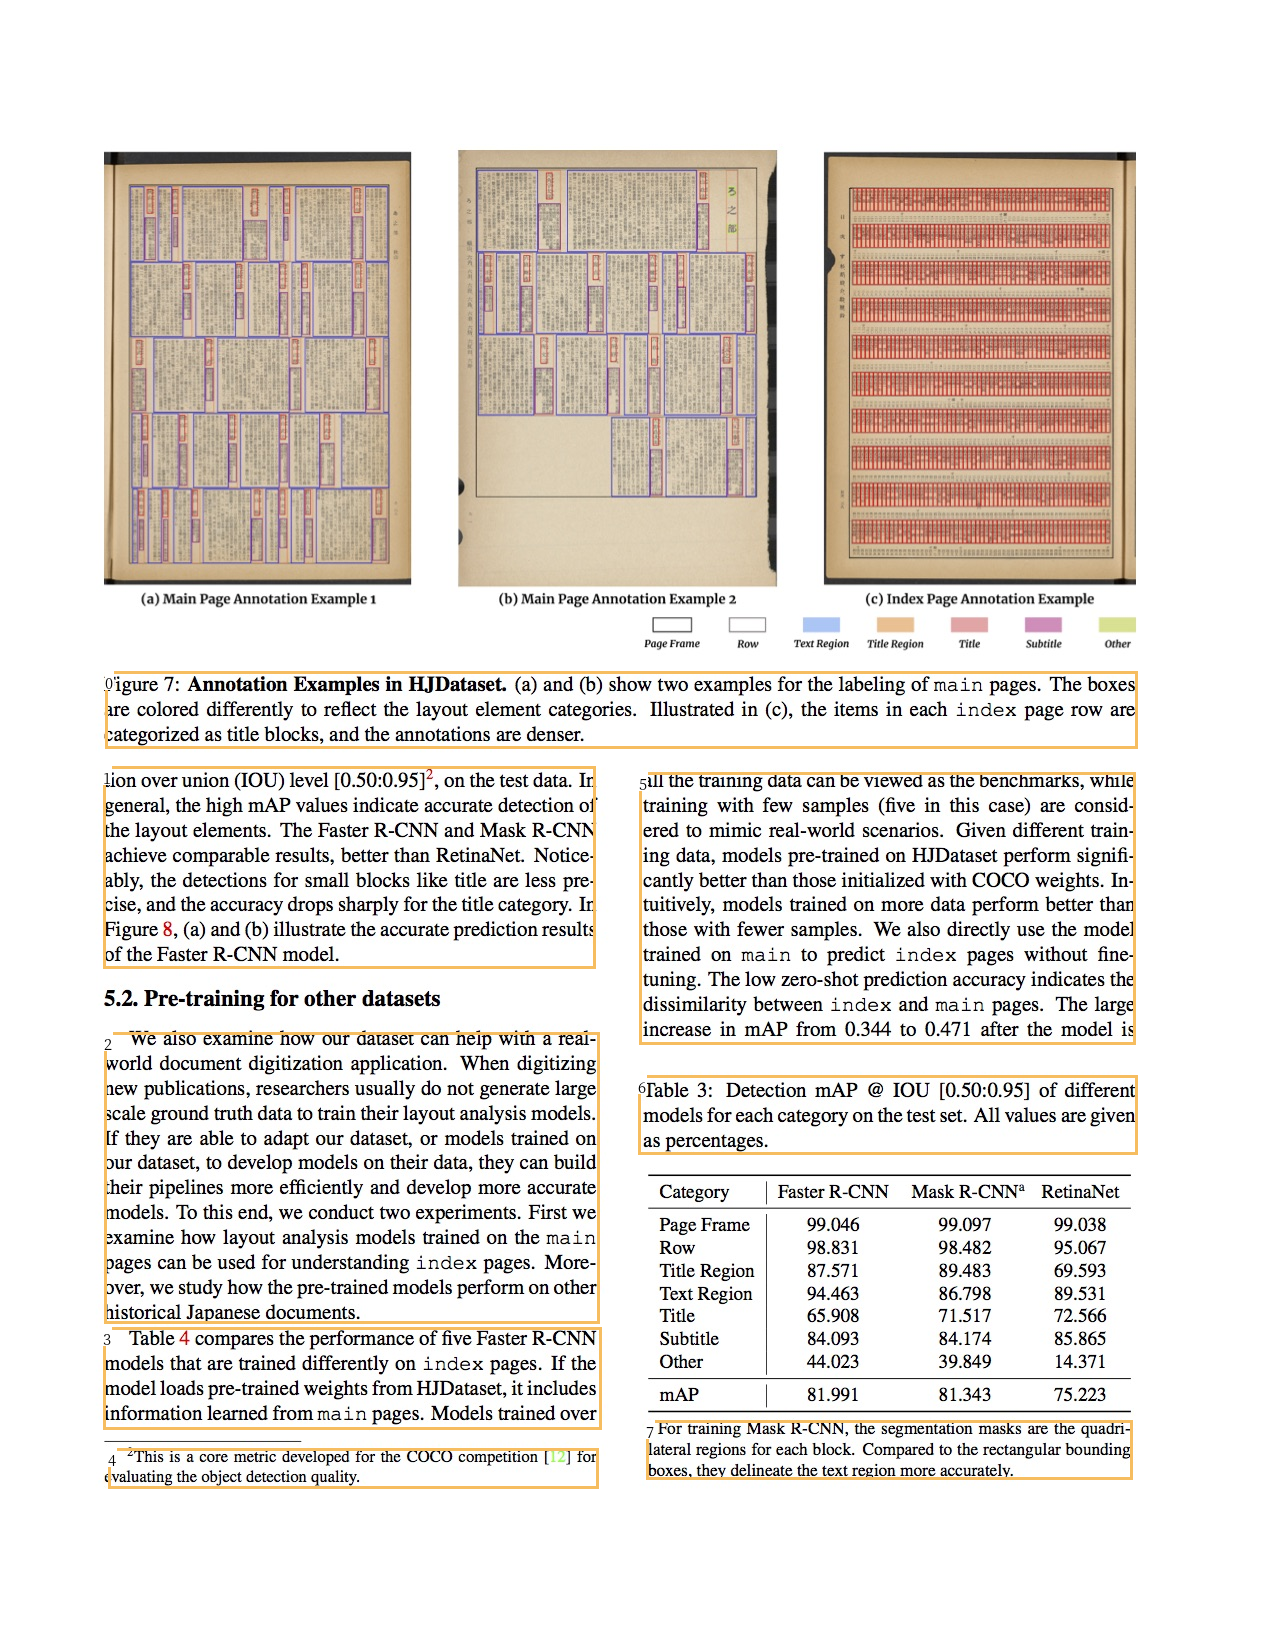

In [ ]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

## Fetch the text inside each text region

We can also combine with the OCR functionality in `layoutparser` to fetch the text in the document. 

In [ ]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [ ]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [ ]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Figure 7: Annotation Examples in HJDataset. (a) and (b) show two examples for the labeling of main pages. The boxes
are colored differently to reflect the layout element categories. Illustrated in (c), the items in each index page row are
categorized as title blocks, and the annotations are denser.
---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP values indicate accurate detection of
the layout elements. The Faster R-CNN and Mask R-CNN
achieve comparable results, better than RetinaNet. Notice-
ably, the detections for small blocks like title are less pre-
cise, and the accuracy drops sharply for the title category. In
Figure 8, (a) and (b) illustrate the accurate prediction results
of the Faster R-CNN model.
---
We also examine how our dataset can help with
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If they are 